## Mushroom Pokédex Project
Author: Alexander Mars
14/04/2020

The goal of this project is to build a CNN capable of predicting a mushroom's species from its photo. 
I have kindly been given access to the mushroomobserver.org database (thank you Jason!), which contains over 1 million images of various fungi.

This database has been built from user-uploaded images that are generally collected whilst foraging. A user who uploads a photo or record of a mushroom creates an 'observation' on the mushroomobserver. At the time of upload a user can postulate what species they think the mushroom is. Over time each observation will have an associated vote of confidence (floating point number from 0-3) which is created by other users voting on what species they think the given observation is. 

For all iterations of the mushroom-pokédex see the week2-mush-pokédex files. In this file I am removing a lot of explanation and simply choosing optimised parameters.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import * # for ease of use
from fastai.metrics import error_rate
import os, math, numpy, pandas as pd


### Loading the Data

I'm going to try build a model first with the top 1000 most commonly observed species on mushroomobserver that have a confidence of at least 2.0

In [3]:
datapath = Path('/notebooks/storage/mushroom-obs-data/')
datapath

PosixPath('/notebooks/storage/mushroom-obs-data')

The below CSVs were generated using the mush-obs-filtering notebook from the raw CSVs provided by mushroomobserver

In [4]:
species = pd.read_csv(datapath/'species_conf2_taxons1-4.csv')
species_obs = pd.read_csv(datapath/'obs_conf2_taxons1-4.csv')
images = pd.read_csv(datapath/'images_observations.csv')

In [5]:
species_obs.head(10)

,Unnamed: 0,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location
0,1,2,3,n3,17/7/04,53.0,NaN,NaN,NaN,2.70604,1
1,6,7,6,s505.0,7/1/05,58.0,NaN,NaN,NaN,2.49991,0
2,7,8,6,s505.0,26/11/04,39.0,NaN,NaN,NaN,2.45144,1
3,8,9,7,s645.0,3/1/03,69.0,NaN,NaN,NaN,2.49991,1
4,9,10,43604,s4404.0,5/1/02,38.0,NaN,NaN,NaN,2.32101,1
5,10,11,43604,s4404.0,15/2/96,38.0,NaN,NaN,NaN,2.32101,1
6,12,13,25700,s593.0,7/1/05,58.0,NaN,NaN,NaN,2.75106,0
7,19,20,16,s2663.0,26/11/04,39.0,NaN,NaN,NaN,2.73580,1
8,23,24,5510,n5510,15/8/96,215.0,NaN,NaN,NaN,2.34786,1
9,28,29,30816,s6094.0,14/7/04,53.0,NaN,NaN,NaN,2.70464,1


In [6]:
species_obs[species_obs['name_id']==5066].head(5)

,Unnamed: 0,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location
150,511,514,5066,s8935.0,6/12/03,4186.0,NaN,NaN,NaN,2.89020,1
151,512,515,5066,s8935.0,5/12/03,4186.0,NaN,NaN,NaN,2.55923,1
152,513,516,5066,s8935.0,15/12/94,1861.0,NaN,NaN,NaN,2.76781,1
247,747,762,5066,s8935.0,12/11/04,12838.0,NaN,NaN,NaN,2.62415,1
341,1339,1386,5066,s8935.0,10/12/06,12838.0,NaN,NaN,NaN,2.45929,1


### Most Commonly Observed Mushrooms

Now getting the top 100 or top 1000 frequently observed obs is trivial using pandas

In [7]:
top_100_taxons = species_obs['taxon_id'].value_counts()[:100].index.tolist()
top_1000_taxons = species_obs['taxon_id'].value_counts()[:1000].index.tolist()
top_100_taxons

['s8935.0',
 's4152.0',
 's8882.0',
 's2852.0',
 's2669.0',
 's8924.0',
 's253.0',
 's2818.0',
 's8869.0',
 's4157.0',
 's7059.0',
 's2883.0',
 's8908.0',
 's2735.0',
 's7118.0',
 's5848.0',
 's3614.0',
 's6080.0',
 's537.0',
 's6024.0',
 's2523.0',
 's7649.0',
 's3868.0',
 's6107.0',
 'n100',
 's2663.0',
 's6913.0',
 's6768.0',
 's174.0',
 's2814.0',
 's57.0',
 's8982.0',
 's2681.0',
 's508.0',
 's132.0',
 'n271',
 's2536.0',
 's496.0',
 'n139',
 's6563.0',
 's8870.0',
 's6324.0',
 's2591.0',
 's2853.0',
 's2854.0',
 's2650.0',
 's5053.0',
 's7558.0',
 's5575.0',
 'n53',
 's4073.0',
 's4455.0',
 'n330',
 's2945.0',
 's2876.0',
 's2994.0',
 's2658.0',
 's6222.0',
 's4709.0',
 's8986.0',
 's6036.0',
 's4176.0',
 's6068.0',
 'n44785',
 's3197.0',
 's620.0',
 'n958',
 's641.0',
 's605.0',
 's2592.0',
 's3205.0',
 's2961.0',
 's134.0',
 'n2710',
 's175.0',
 's4112.0',
 's3854.0',
 's3883.0',
 's8905.0',
 'n362',
 's4616.0',
 's570.0',
 's59.0',
 's580.0',
 'n383',
 's2654.0',
 's2510.0',
 

In [8]:
# Most observed
len(species_obs[species_obs.taxon_id=='s8935.0'].index)

907

In [9]:
species[species.synonym_id==8935.0].iloc[0]['text_name']

'Amanita muscaria'

No surprises there, the most commonly observed mushroom on mushroom observer (species level and below) is Amanita muscaria! 

In [10]:
# 100th most observed
len(species_obs[species_obs.taxon_id=='s3155.0'].index)

165

Now I'm going to see how many images are associated with each taxon_id

In [11]:
images.head(10)

,image_id,observation_id
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
5,6,6
6,7,7
7,8,8
8,9,9
9,10,9


Each image is associated with an observation, and we can see that multiple images may be linked to an observation

In [12]:
def make_taxon_lists(top_taxons):
    taxon_images = {}
    images_per_taxon = {}
    for t_id in top_taxons:
        t_obs = list(species_obs.loc[species_obs.taxon_id==t_id,'id'])
        taxon_images[t_id] = list(images.loc[images.observation_id.isin(t_obs),'image_id'])
        images_per_taxon[t_id] = len(images.loc[images.observation_id.isin(t_obs)].index)
    return taxon_images, images_per_taxon
top_100_images, images_per_100 = make_taxon_lists(top_100_taxons)
top_1000_images, images_per_1000 = make_taxon_lists(top_1000_taxons)

In [13]:
images_per_100

{'s8935.0': 2568,
 's4152.0': 1666,
 's8882.0': 1393,
 's2852.0': 1212,
 's2669.0': 1186,
 's8924.0': 1147,
 's253.0': 815,
 's2818.0': 1112,
 's8869.0': 981,
 's4157.0': 1735,
 's7059.0': 1032,
 's2883.0': 995,
 's8908.0': 882,
 's2735.0': 1139,
 's7118.0': 1485,
 's5848.0': 851,
 's3614.0': 816,
 's6080.0': 840,
 's537.0': 686,
 's6024.0': 741,
 's2523.0': 839,
 's7649.0': 696,
 's3868.0': 580,
 's6107.0': 618,
 'n100': 556,
 's2663.0': 645,
 's6913.0': 1349,
 's6768.0': 625,
 's174.0': 488,
 's2814.0': 624,
 's57.0': 841,
 's8982.0': 645,
 's2681.0': 616,
 's508.0': 610,
 's132.0': 476,
 'n271': 666,
 's2536.0': 633,
 's496.0': 422,
 'n139': 571,
 's6563.0': 637,
 's8870.0': 544,
 's6324.0': 541,
 's2591.0': 435,
 's2853.0': 479,
 's2854.0': 618,
 's2650.0': 671,
 's5053.0': 485,
 's7558.0': 529,
 's5575.0': 426,
 'n53': 575,
 's4073.0': 555,
 's4455.0': 476,
 'n330': 486,
 's2945.0': 647,
 's2876.0': 503,
 's2994.0': 665,
 's2658.0': 493,
 's6222.0': 450,
 's4709.0': 563,
 's8986.0

In [14]:
images_per_1000

{'s8935.0': 2568,
 's4152.0': 1666,
 's8882.0': 1393,
 's2852.0': 1212,
 's2669.0': 1186,
 's8924.0': 1147,
 's253.0': 815,
 's2818.0': 1112,
 's8869.0': 981,
 's4157.0': 1735,
 's7059.0': 1032,
 's2883.0': 995,
 's8908.0': 882,
 's2735.0': 1139,
 's7118.0': 1485,
 's5848.0': 851,
 's3614.0': 816,
 's6080.0': 840,
 's537.0': 686,
 's6024.0': 741,
 's2523.0': 839,
 's7649.0': 696,
 's3868.0': 580,
 's6107.0': 618,
 'n100': 556,
 's2663.0': 645,
 's6913.0': 1349,
 's6768.0': 625,
 's174.0': 488,
 's2814.0': 624,
 's57.0': 841,
 's8982.0': 645,
 's2681.0': 616,
 's508.0': 610,
 's132.0': 476,
 'n271': 666,
 's2536.0': 633,
 's496.0': 422,
 'n139': 571,
 's6563.0': 637,
 's8870.0': 544,
 's6324.0': 541,
 's2591.0': 435,
 's2853.0': 479,
 's2854.0': 618,
 's2650.0': 671,
 's5053.0': 485,
 's7558.0': 529,
 's5575.0': 426,
 'n53': 575,
 's4073.0': 555,
 's4455.0': 476,
 'n330': 486,
 's2945.0': 647,
 's2876.0': 503,
 's2994.0': 665,
 's2658.0': 493,
 's6222.0': 450,
 's4709.0': 563,
 's8986.0

In [15]:
sum(images_per_100.values())/100

658.38

In [16]:
sum(images_per_1000.values())/1000

208.164

Ok so we have 66,046 images of mushrooms across the top 100 most commonly observed taxons.

### Downloading Images

#### Create an image directory

In [4]:
mushroom_images = Path(datapath/'mushroom-images')

In [27]:
# Run this if you want to remove the mushroom-images folder, maybe because you want more images!
import shutil
shutil.rmtree(mushroom_images)

In [28]:
os.mkdir(mushroom_images)

#### Creating classes

Now I'm to create classes that will be used to train the model, these classes will serve as folder and file names for their respective images too.

In [29]:
species.head(5)

,Unnamed: 0,id,text_name,deprecated,correct_spelling_id,synonym_id,rank
0,2,3,Xylaria magnoliae,0,NaN,NaN,4
1,5,6,Xerocomus zelleri,1,NaN,505.0,4
2,6,7,Xerocomus subtomentosus,0,NaN,645.0,4
3,8,9,Xerocomus chrysenteron,1,NaN,504.0,4
4,11,12,Verpa bohemica,0,NaN,2545.0,4


In [20]:
# Synonym_id Rank -> String
# Get all the class names for the most commonly observed taxons
def get_class_name(tax_id, r):
    
    def get_class_subf(condition, id_val, r):
        return species[(species[condition]==float(id_val)) & (species['rank']==r)]
    
    if tax_id[0] == 's':
        c = get_class_subf('synonym_id', tax_id[1:], r)
        if not c.empty:
            return c.iloc[0]['text_name'].replace(' ', '-')
        else:
            '-'.join(get_class_name(tax_id,r-1).split()[:2])
    else:
        c = get_class_subf('id', tax_id[1:], r)
        if not c.empty:
            return c.iloc[0]['text_name'].replace(' ', '-')
        else:
            '-'.join(get_class_name(tax_id,r-1).split()[:2])



In this notebook I am training the model on the top 1000 taxons, hence I use the top_1000_taxons list below:

In [21]:
# You can choose how many classes/how many of the top taxons you want to build the classifier around
classes = []
for t_id in top_1000_taxons:
    c = get_class_name(t_id, 4)
    classes.append(c)

In [22]:
# Sanity check that there are no duplicates in this list
# there should not be if the assimilate taxon_ids algorithm worked properly
len(classes) == len(set(classes))

True

In [23]:
classes

['Amanita-muscaria',
 'Trametes-versicolor',
 'Lepista-nuda',
 'Schizophyllum-commune',
 'Coprinus-comatus',
 'Pleurotus-ostreatus',
 'Lycoperdon-perlatum',
 'Galerina-autumnalis',
 'Boletus-edulis',
 'Mixed-collection',
 'Polyporus-squamosus',
 'Phaeolus-schweinitzii',
 'Hypholoma-fasciculare',
 'Amanita-phalloides',
 'Psilocybe-cyanescens',
 'Laetiporus-sulphureus',
 'Lenzites-betulina',
 'Ganoderma-applanatum',
 'Lycoperdon-pyriforme',
 'Mycena-haematopus',
 'Trichaptum-biforme',
 'Hypomyces-lactifluorum',
 'Lycogala-epidendrum',
 'Mycena-leaiana',
 'Pseudohydnum-gelatinosum',
 'Panellus-stipticus',
 'Psilocybe-ovoideocystidiata',
 'Bolbitius-vitellinus',
 'Hericium-erinaceus',
 'Phyllotopsis-nidulans',
 'Chlorophyllum-molybdites',
 'Leratiomyces-ceres',
 'Fuligo-septica',
 'Tapinella-atrotomentosa',
 'Gomphus-floccosus',
 'Flammulina-velutipes',
 'Armillaria-tabescens',
 'Clavicorona-pyxidata',
 'Omphalotus-illudens',
 'Armillaria-mellea',
 'Ceratiomyxa-fruticulosa',
 'Coprinellus-

#### Fetching Image URLs


For each class, I'm going to create a CSV file containing all the image URLs available through mushroomobserver.org

In [24]:
len(classes)

1000

Note the below URL bypasses the servers at mushroom observer.

In [30]:
base_URL = 'https://images.mushroomobserver.org/320/img_id.jpg'
for i, (t_id, img_ids) in enumerate(top_1000_images.items()):
    os.mkdir(mushroom_images/classes[i])
    filename = classes[i]+'.csv'
    with open(mushroom_images/classes[i]/filename, 'w') as f:
        for img_id in img_ids:
            f.write(base_URL.replace('img_id', str(img_id)))
            f.write('\n')

#### Downloading Images

In [31]:
for i, mushroom in enumerate(classes):
    filename = classes[i]+'.csv'
    path = mushroom_images/classes[i]/filename
    dest = mushroom_images/classes[i]
    download_images(path, dest, max_pics=2500)
    print(i)

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554


555


556


557


558


559


560


561


562


563


564


565


566


567


568


569


570


571


572


573


574


575


576


577


578


579


580


581


582


583


584


585


586


587


588


589


590


591


592


593


594


595


596


597


598


599


600


601


602


603


604


605


606


607


608


609


610


611


612


613


614


615


616


617


618


619


620


621


622


623


624


625


626


627


628


629


630


631


632


633


634


635


636


637


638


639


640


641


642


643


644


645


646


647


648


649


650


651


652


653


654


655


656


657


658


659


660


661


662


663


664


665


666


667


668


669


670


671


672


673


674


675


676


677


678


679


680


681


682


683


684


685


686


687


688


689


690


691


692


693


694


695


696


697


698


699


700


701


702


703


704


705


706


707


708


709


710


711


712


713


714


715


716


717


718


719


720


721


722


723


724


725


726


727


728


729


730


731


732


733


734


735


736


737


738


739


740


741


742


743


744


745


746


747


748


749


750


751


752


753


754


755


756


757


758


759


760


761


762


763


764


765


766


767


768


769


770


771


772


773


774


775


776


777


778


779


780


781


782


783


784


785


786


787


788


789


790


791


792


793


794


795


796


797


798


799


800


801


802


803


804


805


806


807


808


809


810


811


812


813


814


815


816


817


818


819


820


821


822


823


824


825


826


827


828


829


830


831


832


833


834


835


836


837


838


839


840


841


842


843


844


845


846


847


848


849


850


851


852


853


854


855


856


857


858


859


860


861


862


863


864


865


866


867


868


869


870


871


872


873


874


875


876


877


878


879


880


881


882


883


884


885


886


887


888


889


890


891


892


893


894


895


896


897


898


899


900


901


902


903


904


905


906


907


908


909


910


911


912


913


914


915


916


917


918


919


920


921


922


923


924


925


926


927


928


929


930


931


932


933


934


935


936


937


938


939


940


941


942


943


944


945


946


947


948


949


950


951


952


953


954


955


956


957


958


959


960


961


962


963


964


965


966


967


968


969


970


971


972


973


974


975


976


977


978


979


980


981


982


983


984


985


986


987


988


989


990


991


992


993


994


995


996


997


998


999


In [32]:
for i, mushroom in enumerate(classes):
    path = mushroom_images/classes[i]
    verify_images(path, delete=True) 

cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Amanita-muscaria/00002064.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Amanita-muscaria/00002034.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Coprinus-comatus/00000933.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Galerina-autumnalis/00001067.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Mycena-haematopus/00000541.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Mycena-haematopus/00000542.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Trichaptum-biforme/00000786.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Fuligo-septica/00000603.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Clavicorona-pyxidata/00000275.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Armillaria-mellea/00000612.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Hypholoma-lateritium/00000447.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Boletus-ornatipes/00000415.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Laccaria-ochropurpurea/00000436.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Xanthoconium-separans/00000351.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Xanthoconium-separans/00000348.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Xanthoconium-separans/00000349.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Xanthoconium-separans/00000350.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Boletus-bicolor/00000359.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Boletus-bicolor/00000358.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Tricholomopsis-decora/00000191.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Clitocybe-odora/00000169.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Chlorophyllum-rachodes/00000265.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Chlorophyllum-rachodes/00000267.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Chlorophyllum-rachodes/00000264.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Chlorophyllum-rachodes/00000266.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Entoloma-salmoneum/00000148.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Agrocybe-praecox/00000281.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Boletus-rubropunctus/00000071.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Boletus-rubropunctus/00000070.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Boletus-rubropunctus/00000068.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Boletus-rubropunctus/00000069.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Bulgaria-inquinans/00000098.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Catathelasma-ventricosum/00000114.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Psilocybe-baeocystis/00000239.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Amanita-solaniolens/00000084.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Amanita-solaniolens/00000082.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Amanita-solaniolens/00000081.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Amanita-solaniolens/00000083.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/storage/mushroom-obs-data/mushroom-images/Boletellus-ananas/00000134.jpg'>


I noticed whilst visualising the data batch below that one of the top 100 taxon-id's collected was linked to a species called 'mixed-collection'. I'm going to remove this folder before continuing as it will likely contribute to error in the model. 

In [33]:
rm = Path('Mixed-collection')
shutil.rmtree(mushroom_images/rm)

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(mushroom_images,bs=64, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=320, num_workers=4).normalize(imagenet_stats)

In [35]:
print(data.classes)

['Abortiporus-biennis', 'Agaricus-arvensis', 'Agaricus-augustus', 'Agaricus-bernardii', 'Agaricus-bisporus', 'Agaricus-bitorquis', 'Agaricus-californicus', 'Agaricus-campestris', 'Agaricus-hondensis', 'Agaricus-moelleri', 'Agaricus-placomyces', 'Agaricus-subrutilescens', 'Agaricus-sylvicola', 'Agaricus-xanthodermus', 'Agrocybe-erebia', 'Agrocybe-firma', 'Agrocybe-pediades', 'Agrocybe-praecox', 'Agrocybe-putaminum', 'Albatrellus-cristatus', 'Albatrellus-flettii', 'Albatrellus-ovinus', 'Alboleptonia-sericella', 'Aleuria-aurantia', 'Allodus-podophylli', 'Amanita-abrupta', 'Amanita-amerifulva', 'Amanita-amerimuscaria', 'Amanita-amerirubescens', 'Amanita-aprica', 'Amanita-augusta', 'Amanita-banningiana', 'Amanita-bisporigera', 'Amanita-borealisorora', 'Amanita-brunnescens', 'Amanita-calyptroderma', 'Amanita-citrina', 'Amanita-constricta', 'Amanita-crenulata', 'Amanita-daucipes', 'Amanita-farinosa', 'Amanita-flavoconia', 'Amanita-flavorubescens', 'Amanita-frostiana', 'Amanita-fulva', 'Amanit

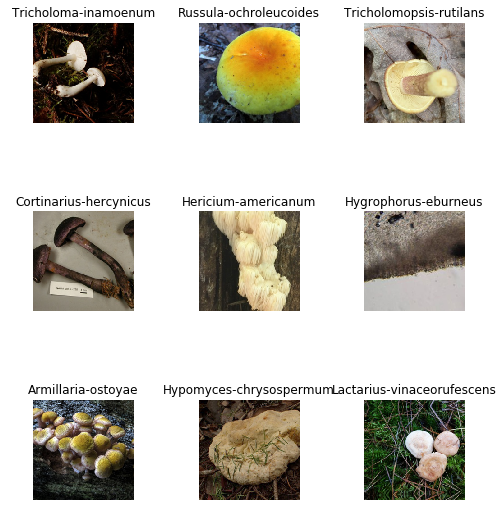

In [36]:
data.show_batch(rows=3, figsize=(7,8))

In [6]:
len(data.train_ds), len(data.valid_ds)

(165058, 41264)

### Training the Top 1000 Taxons Model

Using Resnet34:

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [8]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,4.152571,3.489150,0.706378,18:40
1,3.482678,2.884624,0.608278,17:15
2,3.206776,2.555391,0.549656,17:14
3,2.960027,2.458736,0.530099,17:13


In [11]:
learn.save('1000taxons-4epochs')

In [12]:
learn.unfreeze()

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


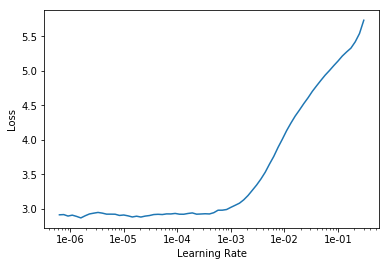

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.827706,2.357577,0.519048,21:03
1,2.510645,2.031220,0.457857,21:06
2,2.122508,1.752125,0.403039,21:06
3,1.816288,1.677290,0.388523,21:05


In [16]:
learn.save('1000taxons-8epochs')

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


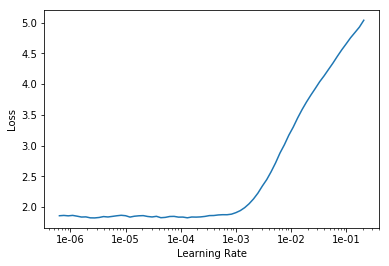

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.098729,1.860229,0.428024,21:01
1,2.124394,1.765090,0.409146,21:05
2,1.752758,1.554322,0.366906,21:05
3,1.561005,1.494895,0.351881,21:04


In [21]:
learn.save('1000taxons-12epochs')

### Removing Junk Images


First I am going to remove images that are not actually of mushrooms from the dataset. These might be microscopy images, or extremely close up such that features can not be determined, or very far away (e.g. photo of a tree with a mushroom on it), or people holding mushrooms.

I DO NOT expect this to dramatically improve the accuracy of the model, as I am quite confident that the noisy images are distributed randomly throughout the dataset. However once removed, I can train any subsequent iterations on this new cleaned dataset, so it is worth doing imo.  

In [21]:
from fastai.widgets import *

In [22]:
db = (ImageList.from_folder(mushroom_images)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [23]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [24]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [26]:
ImageCleaner(ds, idxs, mushroom_images)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Now we can recreate the databunch with the cleaned images:

In [6]:
np.random.seed(42)
db_clean = ImageDataBunch.from_csv(mushroom_images, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
learn_cln = cnn_learner(db_clean, models.resnet34, metrics=error_rate)

In [8]:
learn_cln.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.463306,1.871945,0.491717,04:38
1,1.922415,1.495968,0.404648,03:58
2,1.662268,1.313690,0.356520,03:59
3,1.516275,1.265650,0.341839,03:59


In [9]:
learn_cln.save('c-r34-224-c2+-4e')

In [11]:
learn_cln.unfreeze()

In [12]:
learn_cln.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


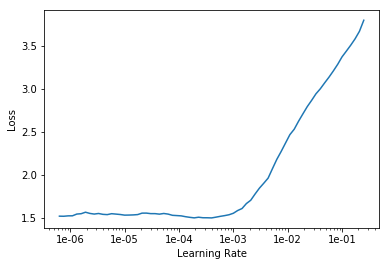

In [13]:
learn_cln.recorder.plot()

In [14]:
learn_cln.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.439239,1.116467,0.306509,04:03
1,1.040688,0.910169,0.251080,04:02


In [15]:
learn_cln.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.118022,0.958865,0.261993,03:59
1,0.794322,0.804603,0.223993,04:02


In [16]:
learn_cln.save('c-r34-224-c2+-8e')